# Examples of how shearforces and bending moments are calculated

In [1]:
# Make the figures a bit larger
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.dpi": 100})

In [2]:
from DAVE import *

Equilibrium-core version = 2.0
default resource folders:
c:\python\miniconda3\envs\book\lib\site-packages\DAVE\resources
C:\Users\beneden\DAVE_models
C:\data\Dave\Book\DAVE-book\DAVE-notebooks
Blender found at: C:\Program Files\Blender Foundation\Blender 2.93\blender.exe


In [3]:
s = Scene()

# Shear forces and bending moments

Shear-forces and bending moments can be calculated in any frame and in any direction.


## Axis with a load

The simplest non-trivial example is a cantilever beam with a load at its end.

Since the bar does not need to deflect we can model this as an frame node. The force is added using a point node and a force node. Leaving all the degrees of freedom of the frame node fixed means that the frame is fixed to the world at its origin.

![image](./images/image000002.png)

In [4]:
s = Scene()
s.new_frame('beam')
s.new_point('point',parent='beam',position=(10,0,0))
s.new_force('load',parent='point',force=(0,0,-20));

Displaying of the shear or moment line can be done in the GUI:

![image](./images/image000003.png)
![image](./images/image000004.png)

Programmatically a load-shear-moment diagram can be obtained from the frame. A small caveat is that the model needs to be solve before doing this.

In [5]:
s.solve_statics()
lsm = s["beam"].give_load_shear_moment_diagram()

Solved to 0.0.


The obtained lsm object contains all the required data for simple and extended plotting:

embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


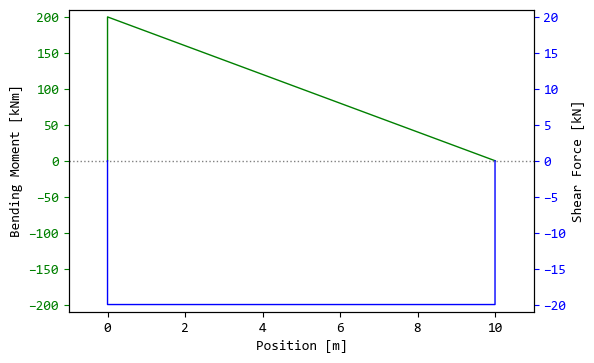

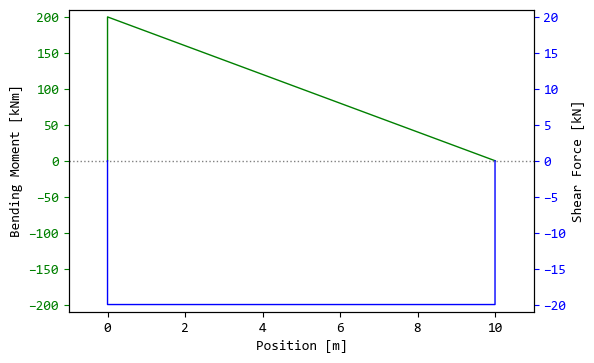

In [6]:
lsm.plot_simple()

The `lsm.plot()` method is tailored for writing to full-page PDFs. For that purpose it can be called with a `"filename"` argument causing it to save to pdf directly.

## Off-centerline loads

Bending is calculated assuming that all forces pass through the X-axis of the analyzed frame (more on that later). Loads that act on a location not on the line are introduced on the nearest point on the line:

![image](./images/image000005.png)

Solved to 0.0.


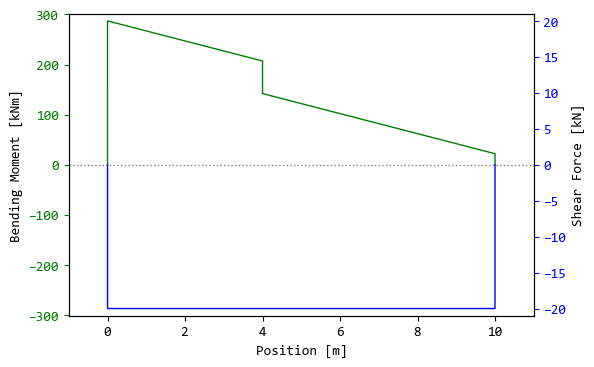

In [7]:
s = Scene()
s.new_frame('beam')
s.new_point('point',parent='beam',position=(10,0,1))
s.new_force('load',parent='point',force=(22,0,-20))
s.new_point('point2',parent='beam',position=(4,0,-1))
s.new_force('load2',parent='point2',force=(-65,0,0));
s.solve_statics()
lsm = s["beam"].give_load_shear_moment_diagram().plot_simple()


## Distributed loads / Footprints

DAVE typically does not care about how loads are distributed. To be able to have distributed loads in shear and moment diagrams a new concept is introduced: **footprints**.

A footprint is a shape that defines over which length a loads is introduced on its parent. The length is the projection of the shape in direction of the X-axis of the analysis frame. The footprint is defined by a number of vertices (3d locations). For a point these define the points of the shape relative to the point.

The following example shows a load at x=10 with its footprint defined from -4 to 4.

![image](./images/image000006.png)

Solved to 0.0.


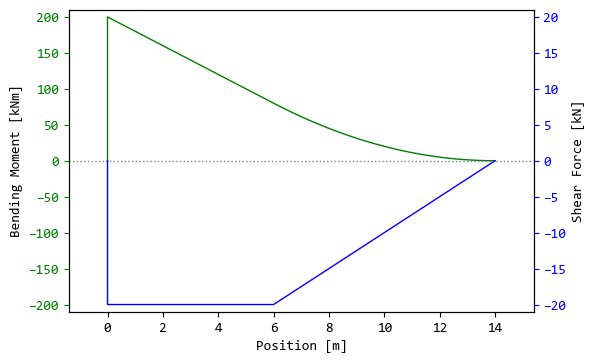

In [8]:
s = Scene()
s.new_frame('beam')
s.new_point('point',parent='beam',position=(10,0,0))
s.new_force('load',parent='point',force=(0,0,-20));
s['point'].footprint = [(-4.0, 0.0, 0.0), (4.0, 0.0, 0.0)]

s.solve_statics()
lsm = s["beam"].give_load_shear_moment_diagram().plot_simple()

A footprint may also be completely outide the point. In that case the resultant of the distributed load on the footprint is calculated to be equal to that of the force:

![image](./images/image000006.png)

Solved to 0.0.


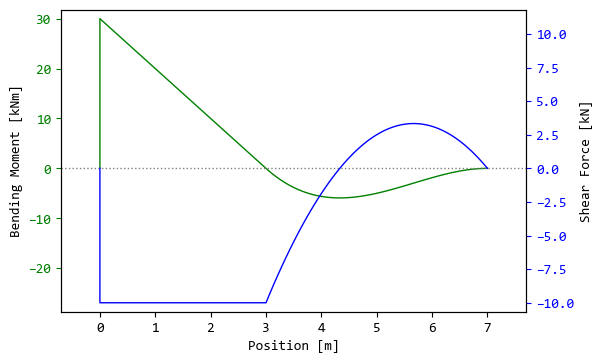

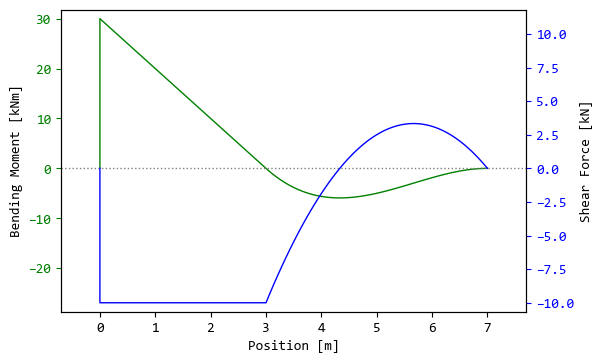

In [9]:
s = Scene()
s.new_frame('beam')
s.new_point('point',parent='beam',position=(3,0,0))
s.new_force('load',parent='point',force=(0,0,-10));
s['point'].footprint = [(0.0, 0.0, 0.0), (4.0, 0.0, 0.0)]

s.solve_statics()
lsm = s["beam"].give_load_shear_moment_diagram()
lsm.plot_simple()

Utilizing the `plot()` method of shows how the force and footprint are combined into a distributed force:

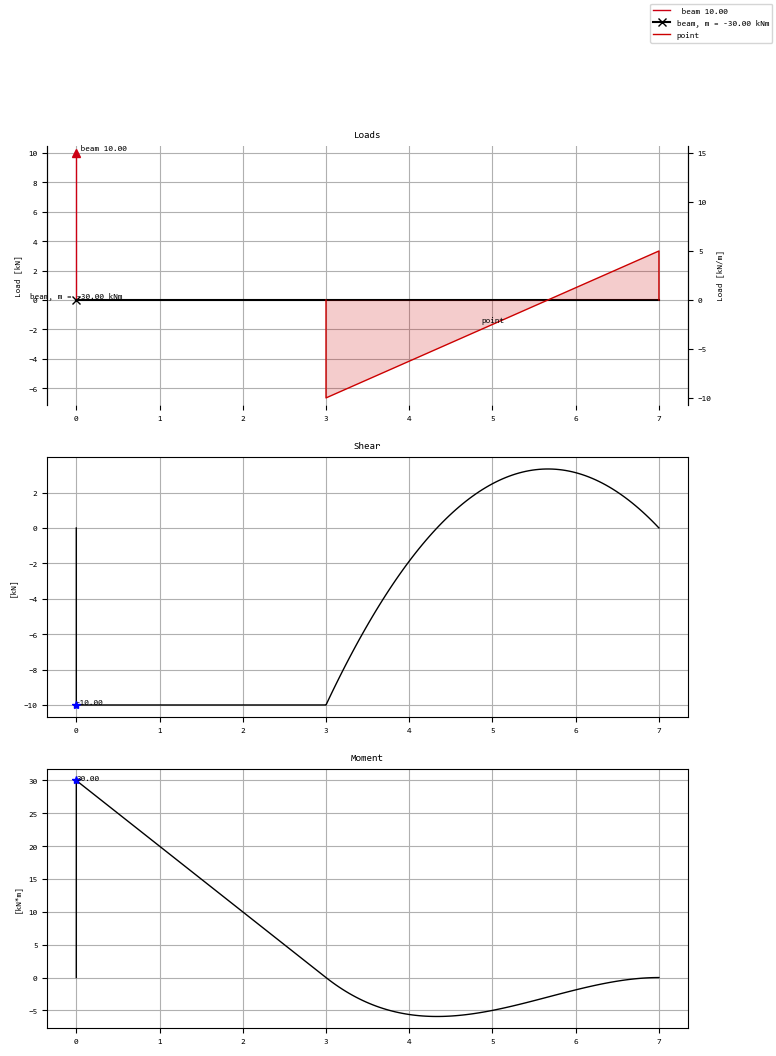

In [10]:
lsm.plot()

## Directions

Calculation of the shear and bending moment is not bound to the X-axis of a frame node. In fact any reference frame can be used:

![image](./images/image000008.png)

Observe that the footprint is projected onto the centerline in a direction perpendicular to the centerline.

Simply provide any other frame to the `give_load_shear_moment_diagram` method.

Solved to 0.0.


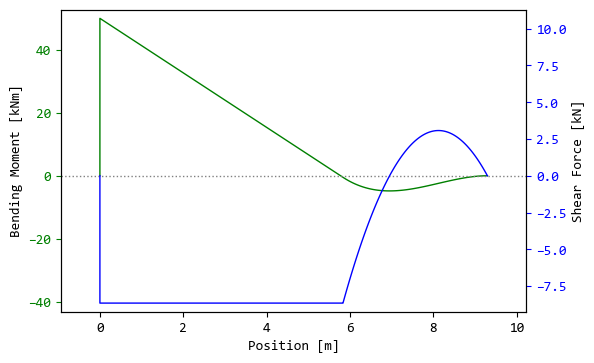

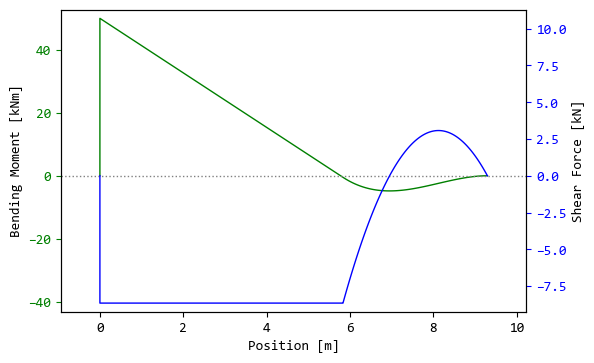

In [11]:
s = Scene()
s.new_frame('beam')
s.new_point('point',parent='beam',position=(5,0,3))
s.new_force('load',parent='point',force=(0,0,-10));
s['point'].footprint = [(0.0, 0.0, 0.0), (4.0, 0.0, 0.0)]

# code for some_other_frame
s.new_frame(name='some_other_frame', rotation=(0,-30,0))

s.solve_statics()
lsm = s["beam"].give_load_shear_moment_diagram(s['some_other_frame'])
lsm.plot_simple()

The maximum shear-load in this situation is the component of the force perpendicular to the centerline: 
cos(30) * 10 = 

In [12]:
-10*np.cos(np.radians(30))

-8.660254037844387

In [13]:
x,shear,moment = lsm.give_shear_and_moment()
np.min(shear)

-8.660254037844387

## Fluids

Fluids work similar but with one major difference:

- Fluids, either as contents of a tank or as buoyancy, result in a distributed load that acts at the location where the vertical force meets the moment/shear axis.
- A distributed load would act the the neasest points on the moment/shear axis.

The difference is illustrated in the following sketch. On the left a buoyancy shape is attached to the frame, on the right a distriubted force. The shear-force lines are shown in blue.

![image](./images/image000009.png)


Solved to 0.0.


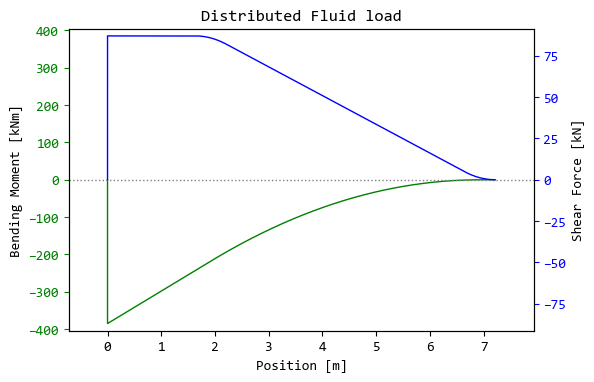

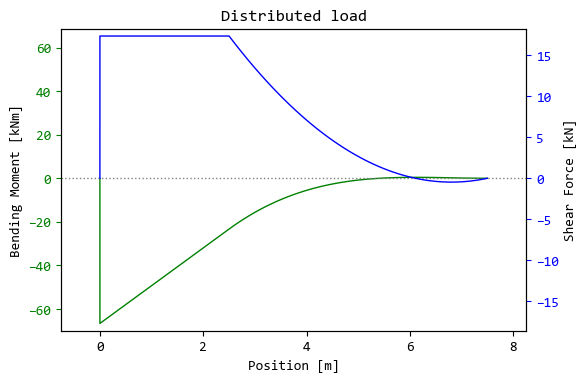

In [14]:
s = Scene()
beam = s.new_frame(name='beam', rotation = (0,30,0))
mesh = s.new_buoyancy(name='Buoyancy mesh',
          parent='beam')
mesh.trimesh.load_file(s.get_resource_path(r'res: cube.obj'), scale = (5.0,2.0,1.0), rotation = (0.0,0.0,0.0), offset = (5,0.0,-1.0))

beam2 = s.new_frame(name='beam2', rotation = (0,30,0), position = (10,0,0))
s.new_point('point',parent='beam2',position=(5,0,-2))
s.new_force('load',parent='point',force=(0,0,20))
s['point'].footprint = [(-2.5, 0.0, 0.0), (2.5, 0.0, 0.0)]

s.solve_statics()

import matplotlib.pyplot as plt
s["beam"].give_load_shear_moment_diagram().plot_simple()
plt.title('Distributed Fluid load')
s["beam2"].give_load_shear_moment_diagram().plot_simple()
plt.title('Distributed load');



## Fluid in partially filled tanks

Behaves just like any other fluid and attaches to the point on the line that is inline with the force.

![image](./images/image000010.png)

In [15]:
s = Scene()
beam = s.new_frame(name='beam', rotation = (0,20,0))

tank = s.new_tank(name='Tank mesh',
          parent='beam')
tank.trimesh.load_file(s.get_resource_path(r'res: cube.obj'), scale = (5.0,1.0,1.0), rotation = (0.0,0.0,0.0), offset = (-7.5,0.0,1.2))
tank.fill_pct = 30

## Self-weight of bodies

RigidBody elements can have a weight.

By default this is a point-load at the position of the cog.

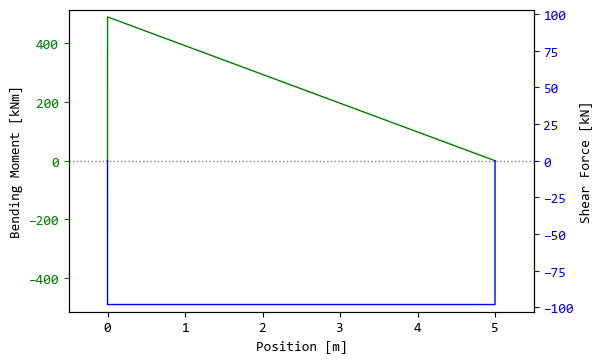

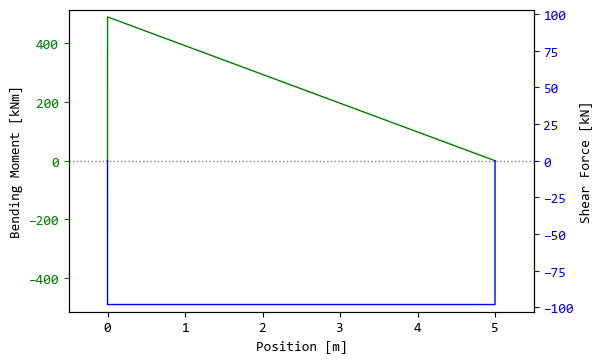

In [16]:
s = Scene()
body = s.new_rigidbody('body',mass=10, cog = (5,0,0))
s.update()

s['body'].give_load_shear_moment_diagram().plot_simple()

Footprints are also used to define the distribution of the self-weight to a parent.

In this example the body is located on "frame" at position x=5. The cog of the body is right above its origin. The footprint of the body defines that the force is applied on "frame" from x=-3 to x=3 relative to the origin of the body. That is x=5-3 = 2 to x= 5+3 = 8 on the frame.

Solved to 0.0.


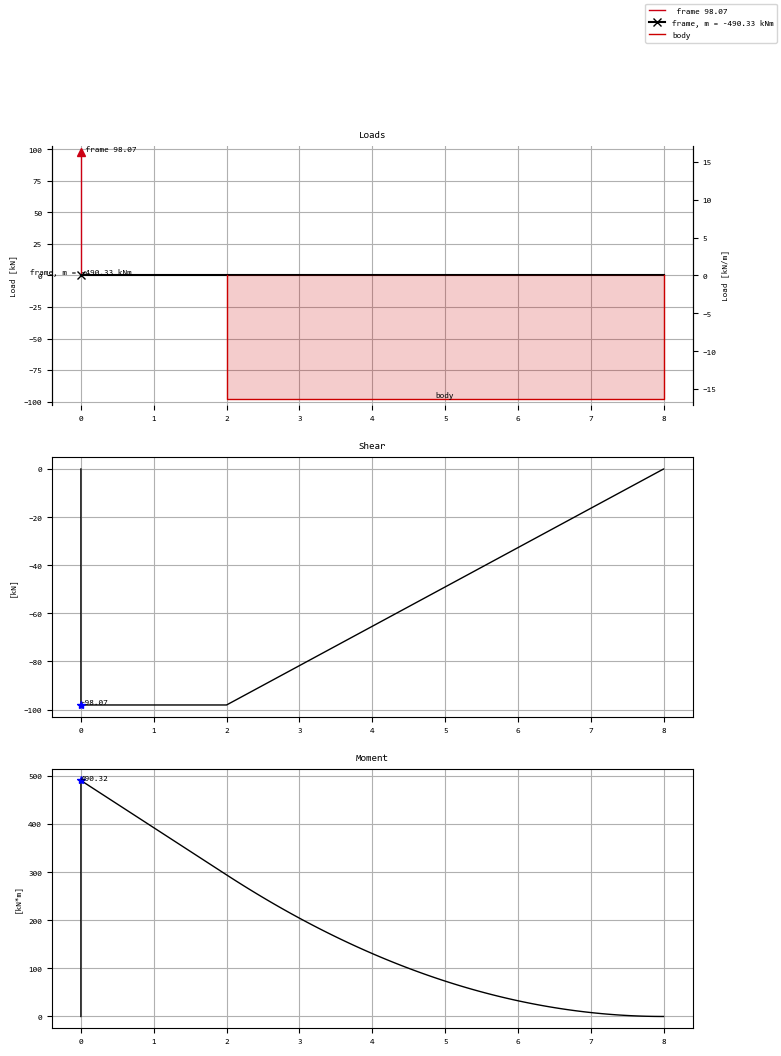

In [17]:
s = Scene()
frame = s.new_frame('frame')
body = s.new_rigidbody('body',parent=frame, mass=10, cog = (0,0,1), position = (5,0,0))
body.footprint = [(-3,0,0),(3,0,0)]
s.solve_statics()

s['frame'].give_load_shear_moment_diagram().plot()

On the body itself, the footprint is used twice:
1. For the distribution of the connection force between the body and the frame
2. For the distribution of the self-weight of the body.

The result is that, in this case, we have two equal and opposite distributed forces acting on "body", hence both the moment and shear are zero.

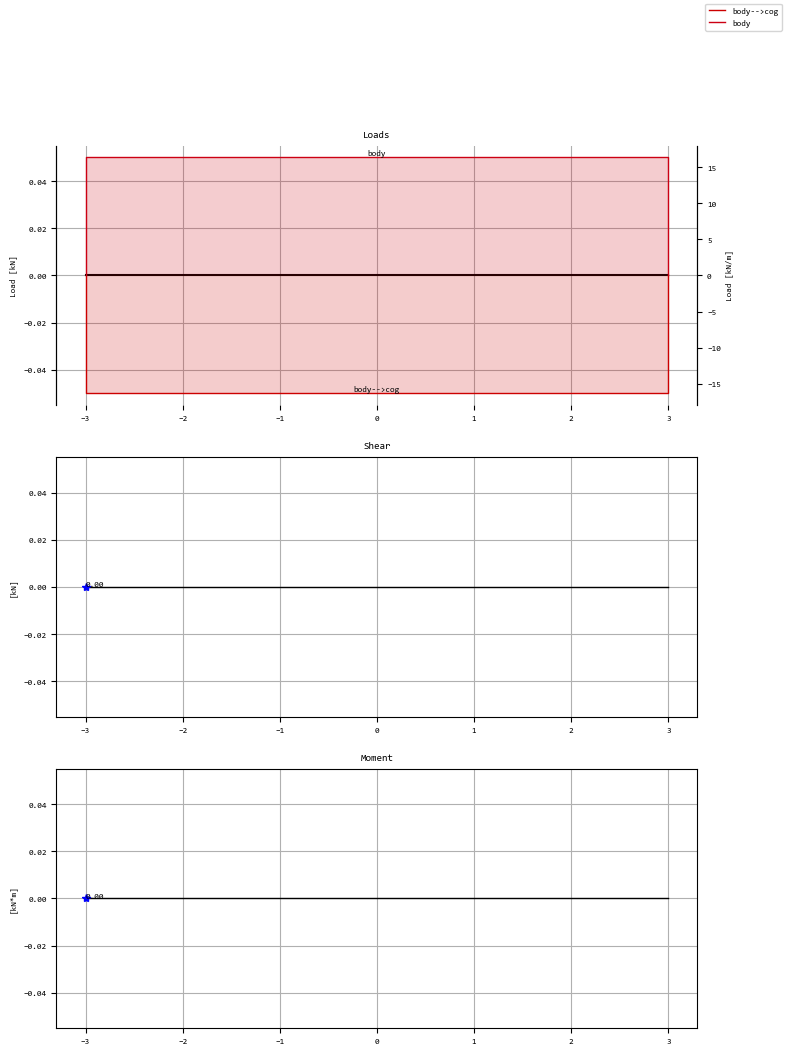

In [18]:
s['body'].give_load_shear_moment_diagram().plot()

A "nicer" example would be a rigid-body suspended from two cables:

In [19]:
s = Scene()
b = s.new_rigidbody('body',mass=10, fixed=False, cog = (0,0,0))
b.footprint = [(-3,0,0),(3,0,0)]

s.new_point('p1', parent=b, position = (-5,0,0))
s.new_point('p2', parent=b, position = ( 5,0,0))

s.new_point('s1', position = (-5,0,0))
s.new_point('s2', position = ( 5,0,0))

s.new_cable('c1','p1','s1', length=3, EA=10000)
s.new_cable('c2','p2','s2', length=3, EA=10000)

# from DAVE.jupyter import show
# show(s)

c2 <Cable>

Solved to 1.8200571645365926e-06.


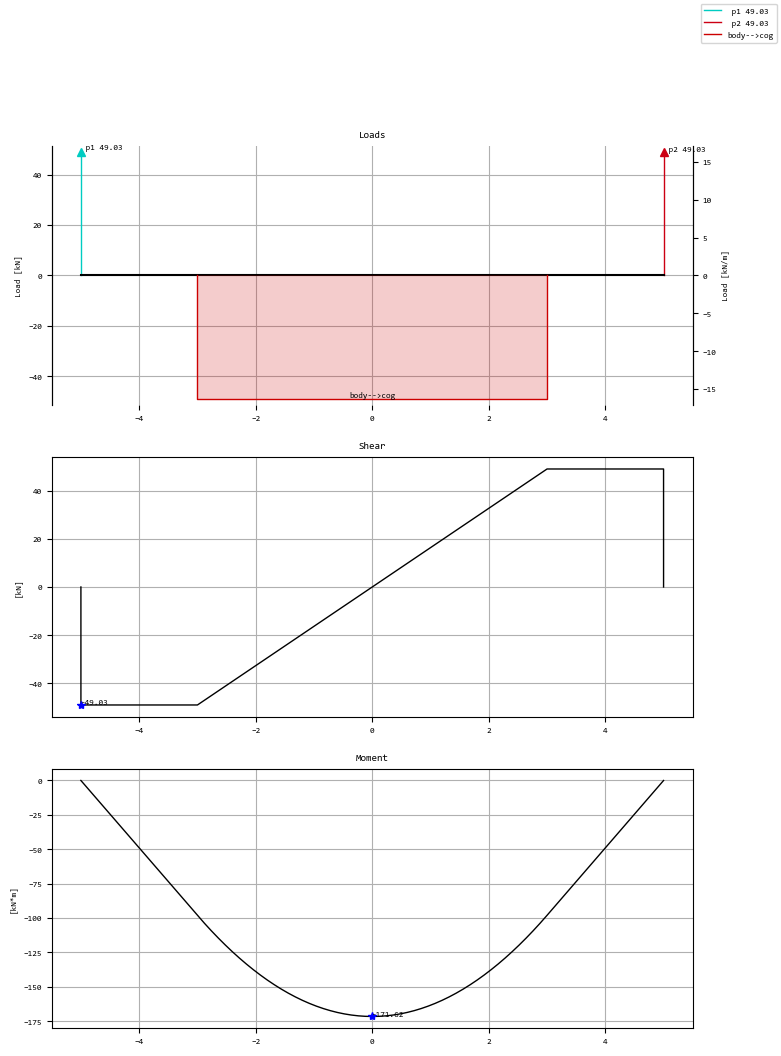

In [20]:
s.solve_statics()
s['body'].give_load_shear_moment_diagram().plot()




